### Johdanto datatieteeseen
# Tampereen kaksiot
## Tuomas Mäkäräinen, 274351

Tämän notebookin tarkoituksena on raapia dataa Tampereen kaksioista Etuovi.com -sivustolta, siistiä sitä, tunnistaa merkittävät ominaisuudet, sekä luoda pari erilaista regressiomallia sen pohjalta.

## Tarvittavat kirjastot

In [1]:
# Tarvittavien kirjastojen tuominen.
from bs4 import BeautifulSoup as bs
from requests import get
from xgboost import XGBRegressor
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import time, os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

print('Done importing')

Done importing


## Datan raapiminen

In [2]:
# Raapimiseen tarvittavien taustatietojen hakeminen, ja määrittäminen.
fileName = 'tampere_kaksiot_etuovi.csv'
headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
baseUrl = 'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481024326&sivu='
html = get(baseUrl, headers=headers)
soup = bs(html.text, 'html.parser')

houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")
tabs = soup.find_all('button', class_="theme__button__1YqFK theme__flat__13aFK theme__button__1YqFK theme__squared__17Uvn theme__neutral__1F1Jf Button__button__3K-jn Pagination__button__3H2wX")
max_tab = int(tabs[-1].contents[0])

In [3]:
# Datan raavinta. Jos raavittu csv-tiedosto löytyy, käytetään sitä.
if fileName in os.listdir('./data/'):
    df = pd.read_csv(f'./data/{fileName}', index_col=0)
    print('Local data found! Imported to DataFrame.')
else:
    loadingBar = []
    limit = 0.1
    data = {
    'Alue': [],
    'Osoite': [],
    'Hinta': [],
    'Koko': [],
    'Vuosi': [],
    'Talotyyppi': [],
    'Sauna': [],
    'Parveke': [],
    }

    for i in range(max_tab):
        clear_output(wait=True)

        baseUrl = f'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1481187938&sivu={i+1}'
        html = get(baseUrl, headers=headers)
        soup = bs(html.text, 'html.parser')

        houseCards = soup.find_all('div', class_="ListPage__cardContainer__39dKQ")

        for temp in houseCards:
            spans = temp.find_all('span', class_='')
            """ price = spans[5].contents[0].replace('\xa0', '')[:-1] # Hinta
            size = spans[7].contents[0] # Koko
            year = spans[10].contents[0] # Vuosi """

            isSize = False
            isPrice = False
            isYear = False

            for item in spans:
                if isPrice:
                    price = item.contents[0].replace('\xa0', '')[:-1]
                    price = float(price.replace(',','.'))
                    isPrice = False
                elif isSize:
                    try:
                        size = float(item.contents[0].replace(',', '.'))
                    except ValueError:
                        size = None
                    isSize = False
                elif isYear:
                    try:
                        year = int(item.contents[0])
                    except ValueError:
                        year = None
                    isYear = False
                else:

                    if 'Hinta' in item.contents and 'Hintamuutos' not in item.contents:
                        isPrice = True
                    elif 'Koko' in item.contents:
                        isSize = True
                    elif 'Vuosi' in item.contents:
                        isYear = True

            raw_address = temp.find('h4').contents[0]
            try:
                address, area, city_ = raw_address.split(', ') # Osoite, Alue
            except ValueError:
                address, city = raw_address.split(', ')
                if 'Opiskelijankatu' in address:
                    area = 'Hervanta'

            raw_type = temp.find('h5').contents[0]
            try:
                house_type, raw_attributes = raw_type.split(' | ') # Talotyyppi
                attributes = raw_attributes.split(' + ') # Ominaisuudet
            except ValueError:
                house_type = raw_type


            data['Alue'].append(area)
            data['Osoite'].append(address)
            data['Hinta'].append(price)
            data['Koko'].append(size)
            data['Vuosi'].append(year)
            data['Talotyyppi'].append(house_type)
            if 's' in attributes:
                sauna = True
            else:
                sauna = False
            if 'p' in attributes:
                balcony = True
            else:
                for item in attributes:
                    if 'parveke' in item:
                        balcony = True
                else:
                    balcony = False

            data['Sauna'].append(sauna)
            data['Parveke'].append(balcony)
        
        if i/max_tab >= limit:
            loadingBar.append('#')
            limit += 0.1
        print('{}{:10}{}'.format('|', ''.join(loadingBar), '|'),'Scraping data...')
        
    df = pd.DataFrame(data)
    df.to_csv('./data/tampere_kaksiot_etuovi.csv')
    print('Done scraping')

Local data found! Imported to DataFrame.


Nyt raavittu data on käytettävissä pandas-kirjaston hyödyllisessä DataFrame -taulukkoformaatissa. Nyt voidaan jatkaa datan tarkasteluun ja siistimiseen.

## Datan tarkastelu ja siistiminen

In [4]:
# Datataulukon muutama ensimmäinen rivi
df.head()

,Alue,Osoite,Hinta,Koko,Vuosi,Talotyyppi,Sauna,Parveke
0,Tesoma,Virontörmänkatu 10,96000.0,55.5,1970.0,Kerrostalo,False,True
1,Villilä,Ratakistonkatu 29,188000.0,62.0,2007.0,Rivitalo,True,False
2,Irjala,Kolarinkatu 21,139000.0,54.5,1973.0,Kerrostalo,False,False
3,Järvensivu,Järvensivuntie 13,199000.0,50.5,2006.0,Kerrostalo,True,False
4,Hervanta,Opinpolku 1,105000.0,46.5,1984.0,Kerrostalo,True,False


In [5]:
# Tilastollisia tietoja datan numeerisista muuttujista
df.describe()

,Hinta,Koko,Vuosi
count,911.000000,910.000000,910.000000
mean,214713.592920,48.032967,2008.656044
std,84596.323935,9.354365,22.537668
min,0.000000,29.000000,1920.000000
25%,155000.000000,40.500000,2012.000000
50%,199900.000000,47.500000,2020.000000
75%,250900.000000,54.500000,2021.000000
max,708550.000000,93.500000,2022.000000


In [6]:
# Tietoja datasarakkeiden määristä ja tyypeistä
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 0 to 910
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alue        911 non-null    object 
 1   Osoite      911 non-null    object 
 2   Hinta       911 non-null    float64
 3   Koko        910 non-null    float64
 4   Vuosi       910 non-null    float64
 5   Talotyyppi  911 non-null    object 
 6   Sauna       911 non-null    bool   
 7   Parveke     911 non-null    bool   
dtypes: bool(2), float64(3), object(3)
memory usage: 51.6+ KB


Viimeisimmän komennon tulosteesta voidaan nähdä joissakin sarakkeissa olevan puuttuvia arvoja (22.4.2020). Koska puuttuvia arvoja on vain parilla rivillä, voidaan ne jättää pois.

In [9]:
df.dropna(inplace=True, axis=0)

indexes = df[(50000 < df['Hinta']) & (df['Hinta'] > 500000)].index
df.drop(indexes, inplace=True)

#indexes = df[df['Hinta']].index
#df.drop(indexes, inplace=True)

df.reset_index(drop=True, inplace=True)
df['Hinta'] = df['Hinta'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alue        903 non-null    object 
 1   Osoite      903 non-null    object 
 2   Hinta       903 non-null    int64  
 3   Koko        903 non-null    float64
 4   Vuosi       903 non-null    float64
 5   Talotyyppi  903 non-null    object 
 6   Sauna       903 non-null    bool   
 7   Parveke     903 non-null    bool   
dtypes: bool(2), float64(2), int64(1), object(3)
memory usage: 44.2+ KB


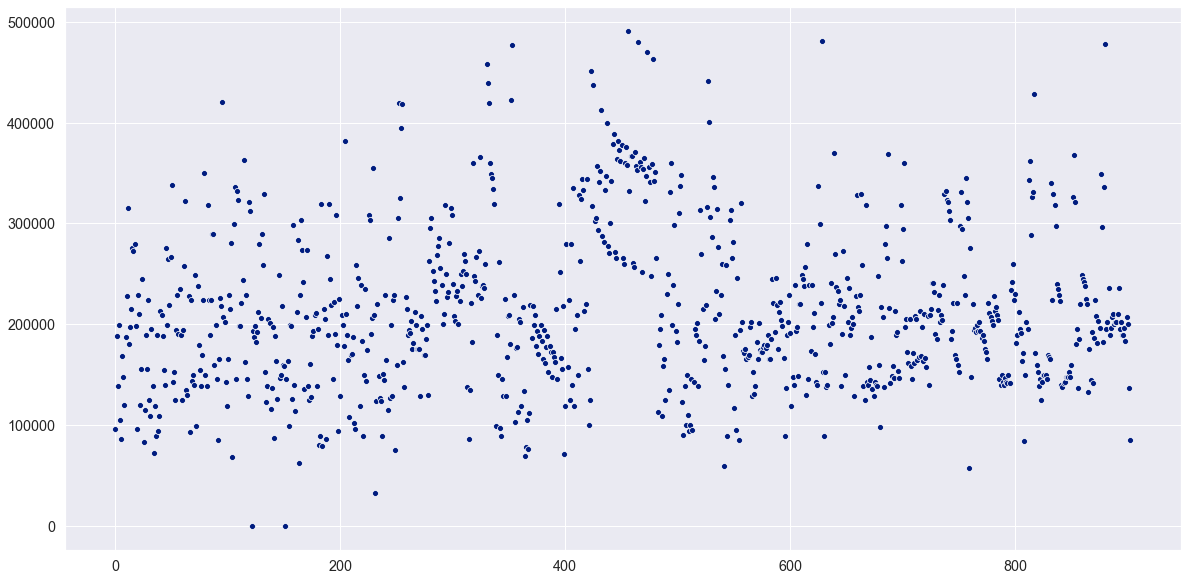

In [39]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df['Hinta'], )

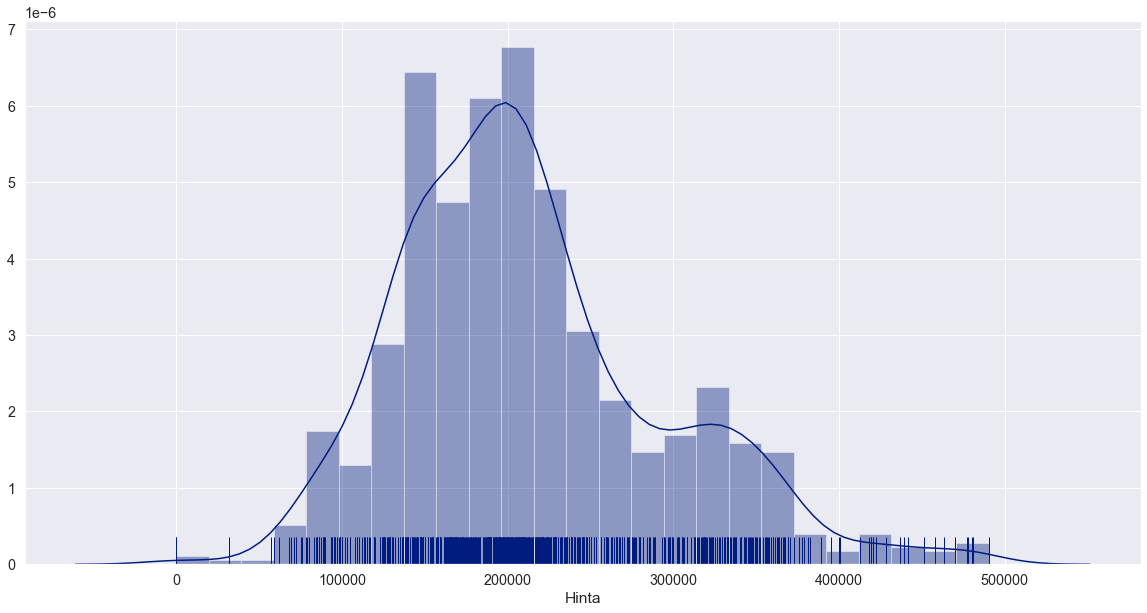

In [41]:
plt.figure(figsize=(20,10))
sns.distplot(df['Hinta'], rug=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85]),
 <a list of 86 Text major ticklabel objects>)

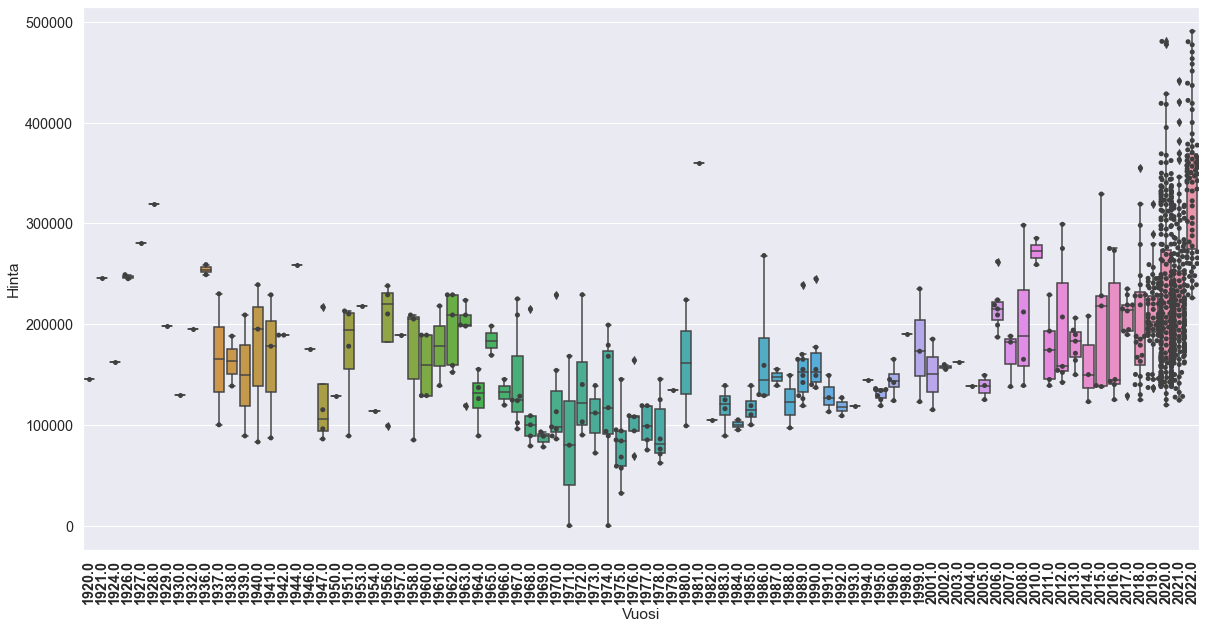

In [26]:
plt.figure(figsize=(20,10))
sns.boxplot(x='Vuosi', y="Hinta", data=df)
sns.swarmplot(x='Vuosi', y="Hinta", data=df, color=".25")

plt.xticks(weight='bold',rotation=90)

## Oleellisten piirteiden tunnistaminen

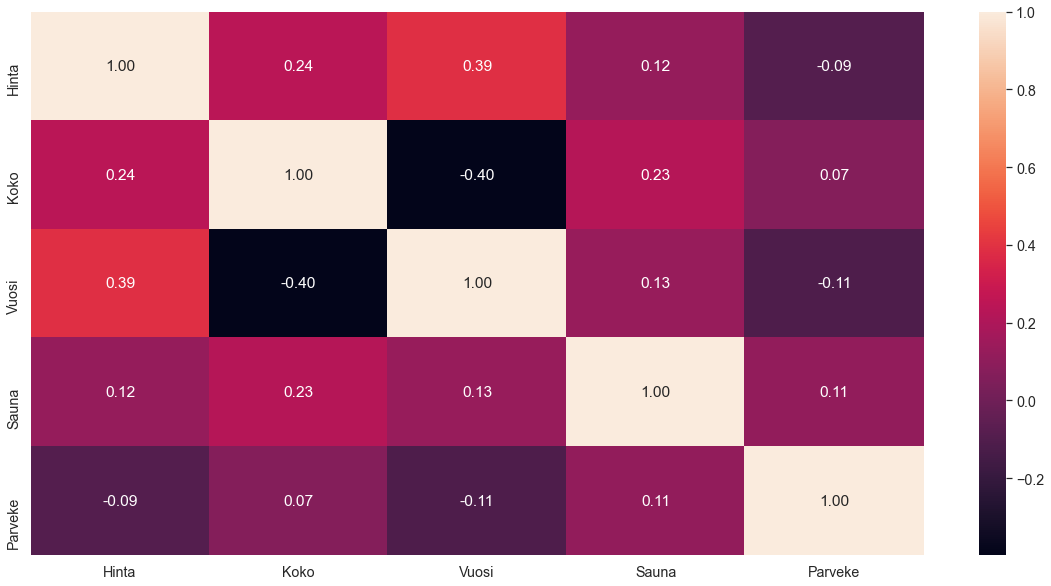

In [27]:
sns.set(font_scale=1.3)
correlation_df = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation_df,annot=True,fmt='.2f')

In [28]:
corr_dict=correlation_df['Hinta'].sort_values(ascending=False).to_dict()
important_cols=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        print(key, round(value,5))
        important_cols.append(key)

Vuosi 0.38931
Koko 0.24103
Sauna 0.12491


In [29]:
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(3,'Score'))

Specs        Score
1   Koko  1156.486172
2  Sauna   531.637421
0  Vuosi   163.768655


[0.40595055 0.58332434 0.01072511]


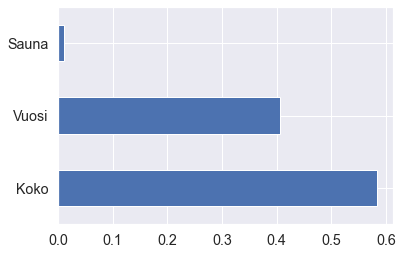

In [30]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest().plot(kind='barh')
plt.show()

<Figure size 2160x1440 with 0 Axes>

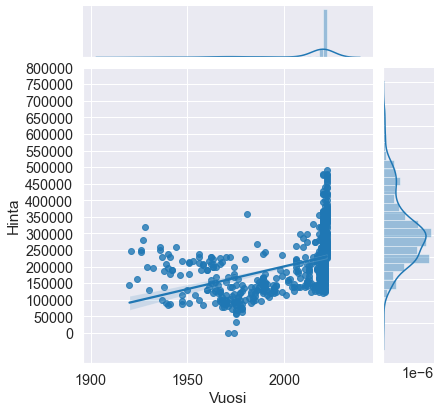

<Figure size 2160x1440 with 0 Axes>

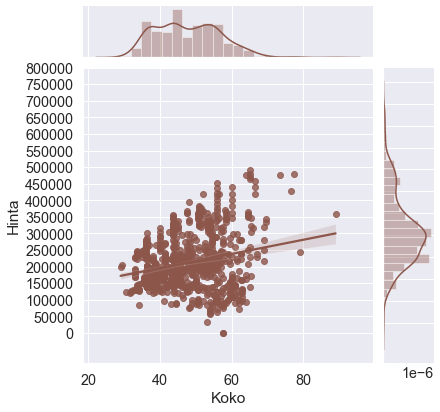

<Figure size 2160x1440 with 0 Axes>

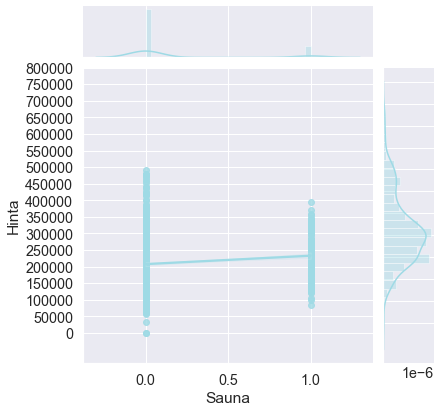

In [31]:
colors=[plt.cm.tab20(each) for each in np.linspace(0, 1, len(important_cols))]
for i,c in zip(important_cols,colors):
    plt.style.use('seaborn-dark-palette')
    plt.figure(figsize=(30,20))
    #plt.scatter(x=train[i], y=train["SalePrice"],c=c,alpha=0.7)
    sns.jointplot(x=i, y='Hinta', data=df, kind="reg",color=c)
    #sb.regplot(x=train[i], y=train["SalePrice"], color=c,fit_reg=True,marker='o',scatter_kws={'s':50})
    plt.xlabel(str(i))
    plt.yticks(np.arange(0,800001,50000))

## Mallien rakentaminen

In [32]:
y = df[['Hinta']]
X = df[important_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(677, 3) (677, 1) (226, 3) (226, 1)


In [33]:
time_start = time.time()

regr = LinearRegression()
regr.fit(X_train, y_train)

train_result = regr.predict(X_train)
test_result = regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)

print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

Time taken to run: 0.016 seconds

Training RMSE: 65288.2938
Testing RMSE: 61535.4113

Training R2: 0.3318
Testing R2: 0.3666


In [34]:
time_start = time.time()

regr = HuberRegressor()
regr.fit(X_train, y_train)

train_result = regr.predict(X_train)
test_result = regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)

print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

Time taken to run: 0.054 seconds

Training RMSE: 76663.6848
Testing RMSE: 76084.5644

Training R2: 0.0787
Testing R2: 0.0317


In [35]:
time_start = time.time()

regr = XGBRegressor()
regr.fit(X_train, y_train)

train_result = regr.predict(X_train)
test_result = regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)

print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

Time taken to run: 0.1279 seconds

Training RMSE: 22022.2701
Testing RMSE: 34719.3567

Training R2: 0.924
Testing R2: 0.7984


In [36]:

ft_weights_xgb = pd.DataFrame(regr.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb.head()

,weight
Vuosi,0.483575
Koko,0.332995
Sauna,0.183430


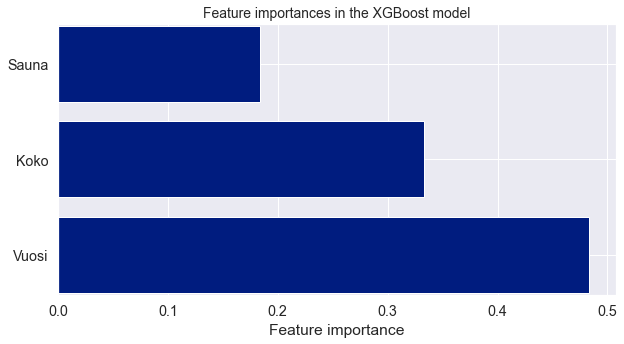

In [37]:
plt.figure(figsize=(10,5))
plt.barh(ft_weights_xgb.index, ft_weights_xgb.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## Hyödyllisiä lähteitä
Data
* https://www.etuovi.com/myytavat-asunnot/tampere

Ominaisuuksien erittely
* https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
* https://www.kaggle.com/darkside92/detailed-examination-for-house-price-top-10

Raapiminen
* https://towardsdatascience.com/looking-for-a-house-build-a-web-scraper-to-help-you-5ab25badc83e

XGB
* https://github.com/gracecarrillo/Predicting-Airbnb-prices-with-machine-learning-and-location-data/blob/gh-pages/Exploring_Edinburgh_Graciela_Carrillo.ipynb